In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy.optimize import curve_fit
%matplotlib widget

f = pickle.load(open('G089.75_5.sav','rb')) 

Text(0.5, 0, '$V_{lsr}$')

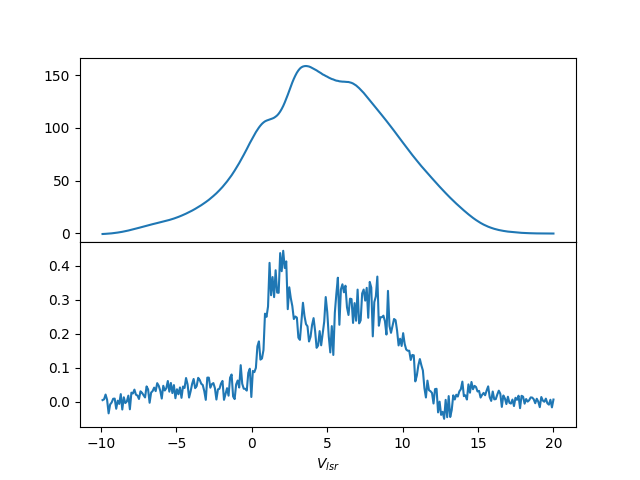

In [2]:
def gaussian(x,h,mu,sig):
    return h*np.exp(-np.power(x-mu,2.)/(2*np.power(sig,2.)))
#Read stokes
vel = f['vel1']
stk_i = f['stk_iall']
stk_q = f['stk_qall']
stk_u = f['stk_uall']
stk_v = f['stk_vall']
fig1,ax1 = plt.subplots(2,sharex=True,gridspec_kw={'hspace':0})
ax1[0].plot(vel,stk_i)
ax1[1].plot(vel,stk_v)
ax1[1].set_xlabel(r'$V_{lsr}$')

In [3]:
from lmfit import Minimizer,Parameters
#define class for stokes I
class component:
    def __init__(self,type,id):
        self.type = type
        self.id = id

    def updateIParams(self,params):
        id = self.id
        self.c = params[f'c{id}']
        self.w = params[f'w{id}']
        if self.type != "HINSA":
            self.h = params[f'h{id}']
        if self.type != "WNM":
            self.t =params[f't{id}']

    def I_emit(self,x,b=0):
        if self.type == 'HINSA':
            return 0
        if self.type == 'WNM':
            return gaussian(x,self.h,self.c+b,self.w)
        if self.type == 'CNM':
            tau = gaussian(x,self.t,self.c+b,self.w)
            return self.h*(1-np.exp(-tau))
        
    def I_passthrough(self,I,x,b=0):
        if self.type == "WNM":
            return I
        tau = gaussian(x,self.t,self.c+b,self.w)
        return I*np.exp(-tau)   

    def updateVParams(self,params):
        id = self.id
        self.b = params[f'b{id}']
        self.berr = params[f'b{id}'].stderr
    
    def V_emit(self,x):
        RCP = 0.5*self.I_emit(x,self.b)
        LCP = 0.5*self.I_emit(x,-self.b)
        return (RCP,LCP)

    def V_passthrough(self,V,x):
        RCP = self.I_passthrough(V[0],x,self.b)
        LCP = self.I_passthrough(V[1],x,-self.b)
        return (RCP,LCP)
    
    def calcB(self):
        zf = 2.8
        dvdf = 2.9979e5/1420.40575e6
        B = self.b/dvdf*2/zf
        Berr = self.berr/dvdf*2/zf
        return (B,Berr)

        

class ZeemanStokes:
    def __init__(self,x,stk_i,stk_v):
        self.Iparams = Parameters()
        self.Vparams = Parameters()
        self.cnmCount = 0
        self.wnmCount = 0
        self.hinsaCount = 0
        self.x = x
        self.stk_i = stk_i
        self.stk_v = stk_v
        self.components = {}
    
    def addCNM(self,id,props,vary=[True,True,True,True,True],
               lbound=[None,None,None,None,None],
               ubound=[None,None,None,None,None]):
        '''
        Takes the properties and bounds of the CNM component as input.
        Adds that CNM to the model
        '''
        self.cnmCount += 1
        self.Iparams.add_many((f'h{id}',props[0],vary[0],lbound[0],ubound[0],None,None),
                             (f't{id}',props[1],vary[1],lbound[1],ubound[1],None,None),
                             (f'c{id}',props[2],vary[2],lbound[2],ubound[2],None,None),
                             (f'w{id}',props[3],vary[3],lbound[3],ubound[3],None,None))
        self.Vparams.add(f'b{id}',props[-1],vary[-1],lbound[-1],ubound[-1],None,None)
        self.components[id] = component('CNM',id)


    def addWNM(self,id,props,vary=[True,True,True],
               lbound=[None,None,None],
               ubound=[None,None,None]):
        '''
        Takes the properties and bounds of the CNM component as input.
        Adds that WNM to the model
        '''
        self.wnmCount += 1
        self.Iparams.add_many((f'h{id}',props[0],vary[0],lbound[0],ubound[0],None,None),
                             (f'c{id}',props[1],vary[1],lbound[1],ubound[1],None,None),
                             (f'w{id}',props[2],vary[2],lbound[2],ubound[2],None,None))
        
        self.Vparams.add(f'b{id}',props[-1],vary[-1],lbound[-1],ubound[-1],None,None)
        self.components[id] = component('WNM',id)
        

    def addHINSA(self,id,props,vary=[True,True,True],
                 lbound=[None,None,None],
                 ubound=[None,None,None]):
        '''
        Takes the properties and bounds of the CNM component as input.
        Adds HINSA to the model
        '''
        self.Iparams.add_many((f't{id}',props[0],vary[0],lbound[0],ubound[0],None,None),
                             (f'c{id}',props[1],vary[1],lbound[1],ubound[1],None,None),
                             (f'w{id}',props[2],vary[2],lbound[2],ubound[2],None,None))
        self.Vparams.add(f'b{id}',props[-1],vary[-1],lbound[-1],ubound[-1],None,None)
        self.hinsaCount += 1
        self.components[id] = component('HINSA',id)

    def performIFit(self,order):
        self.order = order
        fitter = Minimizer(self.fitfuncI,self.Iparams)
        self.Iresult = fitter.minimize(method='leastsq')
        for id in order:
            self.components[id].updateIParams(self.Iresult.params)

    def fitfuncI(self,params):
        model = self.stokesI(params)
        return abs(self.stk_i-model)

    def stokesI(self,params):
        order = self.order
        x = self.x
        tot = 0
        for n,i in enumerate(order):
            comp = self.components[i]
            comp.updateIParams(params)
            I = comp.I_emit(x)
            for j in order[:n]:
                comp_ = self.components[j]
                comp_.updateIParams
                I = comp_.I_passthrough(I,x)
            tot+=I
        return tot

    def plotI(self,ax):
        I_tot = 0
        I_noHINSA_tot = 0
        ax.plot(self.x,self.stk_i)
        for n,id in enumerate(self.order):
            comp = self.components[id]
            if comp.type == 'HINSA':
                continue
            I = comp.I_emit(self.x)
            I_noHINSA = I
            for j in self.order[:n]:
                comp_ = self.components[j]
                if comp_.type != 'HINSA':
                    I_noHINSA = comp_.I_passthrough(I_noHINSA,self.x)
                I = comp_.I_passthrough(I,self.x)
            ax.plot(self.x,I_noHINSA,label=id)
            I_tot += I
            I_noHINSA_tot += I_noHINSA
        ax.plot(self.x,I_tot,label='fit')
        ax.plot(self.x,I_noHINSA_tot-I_tot,label = 'HINSA')
        ax.legend()

    def performVFit(self,e=[None,None,None,None]):
        self.Vparams.add('e',e[0],e[1],e[2],e[3],None,None)
        fitter = Minimizer(self.fitfuncV,self.Vparams)
        self.Vresult = fitter.minimize(method='leastsq')
        for id in self.order:
            self.components[id].updateVParams(self.Vresult.params)

    def fitfuncV(self,params):
        model = self.stokesV(params)
        return abs(self.stk_v-model)

    def stokesV(self,params):
        order = self.order
        x = self.x
        tot_RCP = 0
        tot_LCP = 0
        for n,i in enumerate(order):
            comp = self.components[i]
            comp.updateVParams(params)
            V_RCP,V_LCP = comp.V_emit(x)
            for j in order[:n]:
                comp_ = self.components[j]
                comp_.updateVParams(params)
                V = (V_RCP,V_LCP)
                V_RCP,V_LCP = comp_.V_passthrough(V,x)
            tot_RCP += V_RCP
            tot_LCP += V_LCP
        return tot_RCP-tot_LCP + params['e']*self.stk_i

    def plotV(self,plotComponents=False,pc=False):
        V_tot_RCP = 0
        V_tot_LCP = 0
        V_noHINSA_tot_RCP = 0
        V_noHINSA_tot_LCP = 0
        fig1,ax1 = plt.subplots(1)

        ax1.plot(self.x,self.stk_v-self.Vresult.params['e']*stk_i)

        for n,id in enumerate(self.order):
            comp = self.components[id]
            if comp.type == 'HINSA':
                continue
            V = comp.V_emit(self.x)
            V_noHINSA = V
            for j in self.order[:n]:
                comp_ = self.components[j]
                if comp_.type != 'HINSA':
                    V_noHINSA = comp_.V_passthrough(V_noHINSA,self.x)
                V = comp_.V_passthrough(V,self.x)
                ax1.plot(self.x,V[0]-V[1])
            #ax1.plot(self.x,V_noHINSA,label=id)
            V_tot_RCP += V[0]
            V_tot_LCP += V[1]
            V_noHINSA_tot_RCP += V_noHINSA[0]
            V_noHINSA_tot_LCP += V_noHINSA[1]
        V_tot = V_tot_RCP - V_tot_LCP
        V_noHINSA_tot = V_noHINSA_tot_RCP - V_noHINSA_tot_LCP
        print(np.max(self.Vresult.params['e']*stk_i))
        print(np.max(V_tot))
        fit = V_tot #+ self.Vresult.params['e']*self.stk_i
        resV = self.stk_v - fit - self.Vresult.params['e']*self.stk_i
        HINSAV = V_tot - V_noHINSA_tot
        ax1.plot(self.x,fit,label='fit')
        ax1.plot(self.x,HINSAV,label = 'HINSA')
        ax1.legend()
        if plotComponents == True:
            self.plotComponents(pc,resV,HINSAV)

    def plotComponents(self,pc,res,HINSAV):
        fig,ax = plt.subplots(len(self.order),figsize=(6,2*len(self.order)),sharex=True,gridspec_kw={'hspace':0})
        for n,id in enumerate(self.order):
            comp = self.components[id]
            if comp.type !='HINSA':
                V = comp.V_emit(self.x)
                if not pc:
                    for j in self.order[:n]: 
                        comp_ = self.components[j]
                        if comp_.type != 'HINSA':
                            V = comp_.V_passthrough(V,self.x)
                V = V[0]-V[1] 
            else:
                V = HINSAV
            B = comp.calcB()
            ax[n].set_xlim(-10,20)
            ax[n].plot(vel, V,'r-')
            ax[n].step(vel, res+V,'k-', label=r"data",linewidth=0.5)
            ax[n].text(0.08,1-0.15*8/6, self.order[n],horizontalalignment='center',verticalalignment='center',
                    transform=ax[n].transAxes, fontsize=10)
            ax[0].text(0.25,1-0.15*8/6,"{:2.1f}\u00B1{:2.1f} ".format(B[0],B[1])+r'$\mu G$' ,horizontalalignment='center',verticalalignment='center',
                    transform=ax[n].transAxes, fontsize=10)





In [5]:
#Define number of cnm and wnm components and their starting parameters


stokesIModel = ZeemanStokes(vel,stk_i,stk_v)

stokesIModel.addCNM('C1',
             [75,2,3.1,1.46,0.01],
             [True,True,True,True,True],
             [0,0.1,-20,0,-0.1],
             [300,10,20,2.3,0.1])

stokesIModel.addCNM('C2',
             [126.82,1.02,10.33,1,0.01],
             [True,True,True,True,True],
             [20,0.05,9,0,-0.1],
             [300,10,20,2.5,0.1])

stokesIModel.addCNM('C3',
             [120,3,8.01,1.5,0.01],
             [True,True,True,True,True],
             [0,0,6,0,-0.1],
             [200,100,9,2,0.1])

stokesIModel.addWNM('W1',
             [12,5,6,-0.05],
             [True,True,True,True],
             [0,-4,0,-0.1],
             [100,15,10,1e-3])

stokesIModel.addHINSA('H1',
                      [0.1,1.89,1,0.04],
                      [True,True,True,True],
                      [0,1.5,0,-0.1],
                      [100,2,2,0.1])
#Define order
order = ['H1','C1','C2','C3','W1']
stokesIModel.performIFit(order = order)
print(stokesIModel.Iresult.message)
display(stokesIModel.Iresult.params)

Fit succeeded.


name,value,standard error,relative error,initial value,min,max,vary
hC1,299.996182,129.370673,(43.12%),75,0.00000000,300.000000,True
tC1,0.22536779,0.14213505,(63.07%),2,0.10000000,10.0000000,True
cC1,1.69634120,0.19027212,(11.22%),3.1,-20.0000000,20.0000000,True
wC1,1.58730040,0.05966632,(3.76%),1.46,0.00000000,2.30000000,True
hC2,52.6888577,1.52145861,(2.89%),126.82,20.0000000,300.000000,True
tC2,1.18712358,0.02632620,(2.22%),1.02,0.05000000,10.0000000,True
cC2,11.2543755,0.04720973,(0.42%),10.33,9.00000000,20.0000000,True
wC2,1.87168122,0.02801276,(1.50%),1,0.00000000,2.50000000,True
hC3,145.649707,0.57898926,(0.40%),120,0.00000000,200.000000,True
tC3,13.4586261,3.49138276,(25.94%),3,0.00000000,100.000000,True


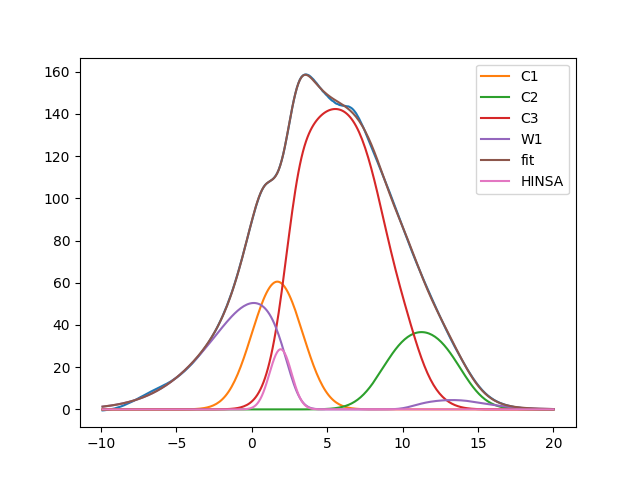

In [6]:
fig,ax = plt.subplots(1)
stokesIModel.plotI(ax)

In [7]:
stokesIModel.performVFit(e=[0.3e-4,True,0,0.02])
display(stokesIModel.Vresult.message)
display(stokesIModel.Vresult.params)


'Fit succeeded.'

name,value,standard error,relative error,initial value,min,max,vary
bC1,0.00318995,7.7521e-04,(24.30%),0.01,-0.10000000,0.10000000,True
bC2,0.00462907,5.8780e-04,(12.70%),0.01,-0.10000000,0.10000000,True
bC3,-0.00551631,4.5513e-04,(8.25%),0.01,-0.10000000,0.10000000,True
bW1,-3.5479e-04,9.8754e-04,(278.35%),-0.05,-0.10000000,1.0000e-03,True
bH1,0.00288895,5.9730e-04,(20.68%),0.04,-0.10000000,0.10000000,True
e,0.00156109,4.8295e-05,(3.09%),3e-05,0.00000000,0.02000000,True


0.2477367979818659
0.12596362706207742


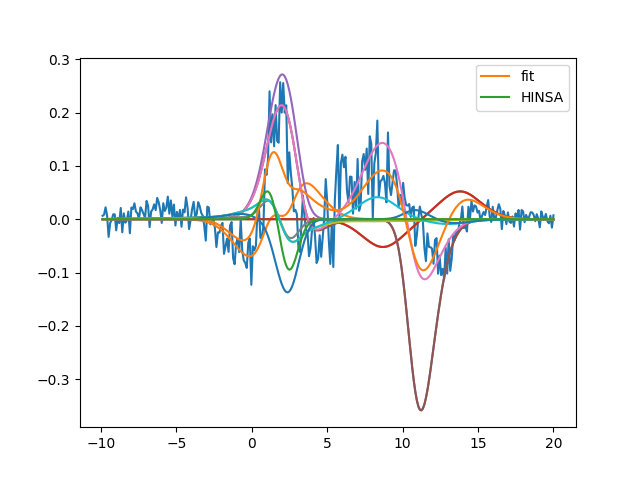

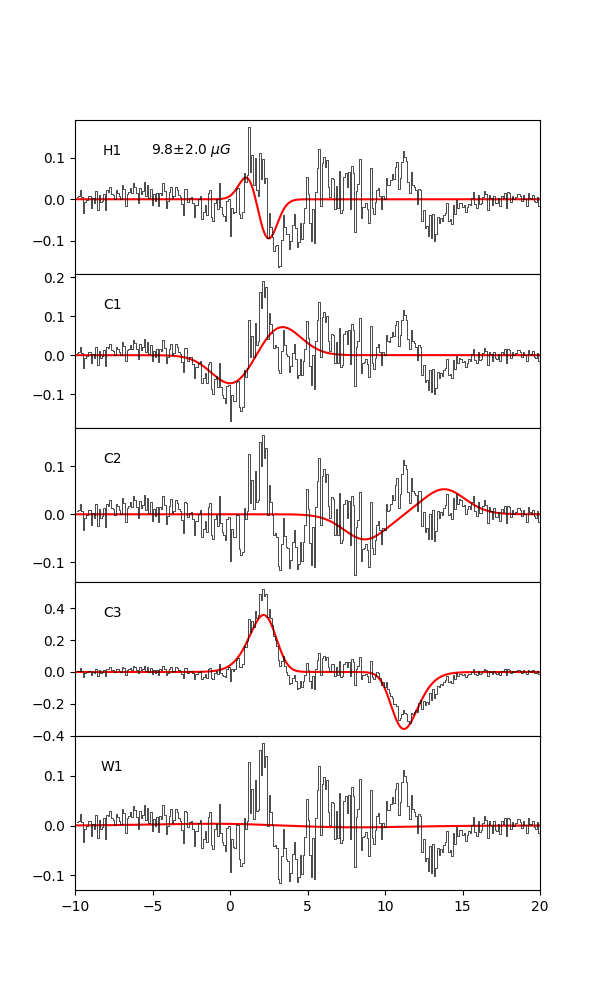

In [8]:
stokesIModel.plotV(True,False)